This file contains the code to for analyze the U and V from CPD

- Combine U and V, together

- Output Brain vecs to plot

In [1]:
import sys
sys.path.append("../../mypkg")
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT, FIG_ROOT
import importlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from functools import partial
from pprint import pprint

from collections import defaultdict as ddict
from easydict import EasyDict as edict


%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [6]:
from utils.misc import load_pkl, save_pkl_dict2folder, load_pkl_folder2dict

## Load data

In [15]:
_paras = edict()
_paras.folder_name = "method8"
_paras.save_dir = RES_ROOT/_paras.folder_name

In [16]:
cur_res = load_pkl_folder2dict(_paras.save_dir, including=["CPD*"], verbose=True)

Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl


In [17]:
cur_res.keys()

dict_keys(['CPDresult'])

## Dim reduction

In [20]:
U = cur_res.CPDresult[0]
V = cur_res.CPDresult[1]

In [87]:
# spec
from utils.misc import spec_emb_red

com_Us = []
for ix in range(20):
    curU, curV = U[:, ix], V[:, ix]
    both_info = np.stack([curU, curV]).T
    com_U = spec_emb_red(both_info)
    com_Us.append(np.squeeze(com_U))
com_Us = np.array(com_Us).T

In [72]:
# PCA
# It seems it works not very good
from sklearn.decomposition import PCA
for ix in range(20):
    curU, curV = U[:, ix], V[:, ix]
    both_info = np.stack([curU, curV]).T
    pca = PCA(n_components=2)
    
    pca.fit(both_info)
    res = pca.transform(both_info)
    print(pca.explained_variance_ratio_)

[0.50729882 0.49270118]
[0.5709278 0.4290722]
[0.57548489 0.42451511]
[0.50907397 0.49092603]
[0.5447901 0.4552099]
[0.53224875 0.46775125]
[0.54706111 0.45293889]
[0.53438633 0.46561367]
[0.55663021 0.44336979]
[0.51991488 0.48008512]
[0.58078148 0.41921852]
[0.59348228 0.40651772]
[0.58743873 0.41256127]
[0.58219224 0.41780776]
[0.54837836 0.45162164]
[0.52669167 0.47330833]
[0.50376239 0.49623761]
[0.53178216 0.46821784]
[0.53974375 0.46025625]
[0.50439078 0.49560922]


In [96]:
# Naive way np.sqrt(U**2+V**2)
com_Us = []
for ix in range(20):
    curU, curV = U[:, ix], V[:, ix]
    com_U = np.sqrt(curU**2+curV**2)
    com_Us.append(np.squeeze(com_U))
com_Us = np.array(com_Us).T

## Plot


In [76]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

In [79]:
# truncate small value in vec
def _cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

In [92]:
# plot the corrmat with 7 canonical nets
def _corr_plot(vecs, cutoff=0.05, trun_fn=lambda x:x, trans_fn=np.abs):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    assert vecs.shape[0] == 68
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        curU = trun_fn(curU)
        for iy, kz in enumerate(_paras.canon_net_names):
            curV = _paras.canon_nets[kz]
            curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    trans_corrMat = trans_fn(corrMat)
    sns.heatmap(trans_corrMat,  yticklabels=_paras.canon_net_names, 
                xticklabels=np.arange(1, vecs.shape[-1]+1),
                cmap="bwr", center=0, 
                vmin=-1, vmax=1, annot=np.round(trans_corrMat, 2))
    return corrMat

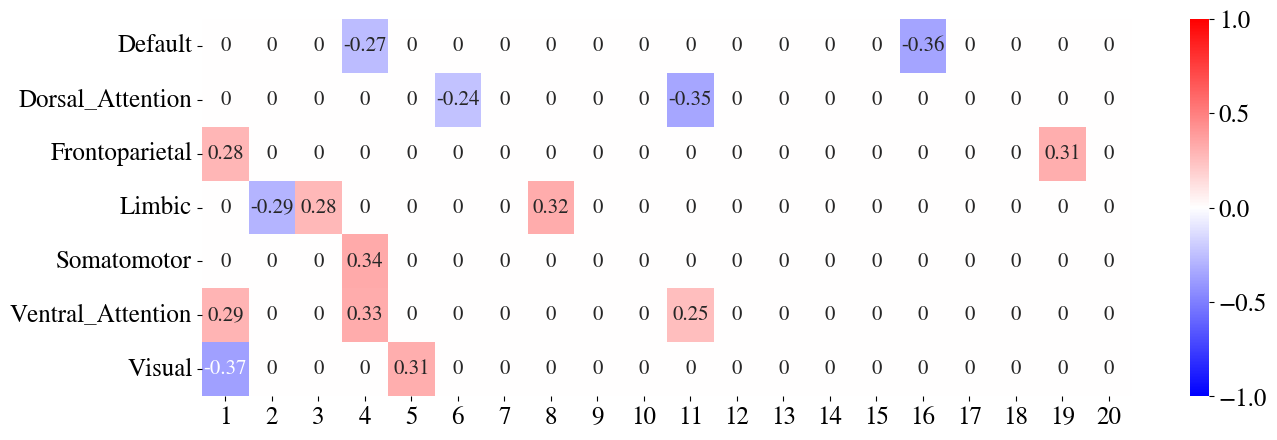

In [95]:
tfn1 = partial(_cumsum_trunc, cutoff=0.95)
corr_mat = _corr_plot(com_Us, cutoff=0.05, trun_fn=tfn1, trans_fn=lambda x:np.array(x));

## Save 

In [98]:
from constants import REGION_NAMES, REGION_NAMES_WLOBE
from utils.standardize import minmax, minmax_mat, minmax_plotting
from utils.brain_plot import reorder_U, U_2brain_vec, obt_FC_exp

# save the files for brainplotting
def save_brainplotting_vec(vecs, filname_prefix, order=2, is_csv=False):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    for ix in range(vecs.shape[1]):
        cur_sing_vec = vecs[:, ix]
        out_vec_raw = minmax_plotting(cur_sing_vec, order=order)
        out_vec = U_2brain_vec(reorder_U(out_vec_raw))
        np.savetxt(RES_ROOT/f"./{filname_prefix}_{ix+1}.txt", out_vec)
        if is_csv:
            pd.DataFrame({"Name": REGION_NAMES,
                      "Vec": cur_sing_vec}).to_csv(paras.res_dir/f"./{filname_prefix}_{ix+1}.csv",
                                                          index=False)

In [100]:
#save_brainplotting_vec(np.abs(com_Us), "m8_sqsum_abs_comU_order3", 3)
save_brainplotting_vec(com_Us, "m8_sqsum_raw_comU_order2", 2)